> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Univariate LSTM

This tutorial is to demonstrate the process in build LSTM for the Univariate Time Series Data,<br>
It consists of 2 major part which are :

1. The Demostration of Building LSTM using Synthetic data 
2. Exercise of building LSTM using shampoo sales data.

First, we will show the step in building the LSTM : 

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)<br>
Step 2. Model Configuration (Vanila LSTM , Stacked LSTM , Bidirectional LSTM)<br>
Step 3. Train the model <br>
Step 4. Validate the model using graph <br>
Step 5. Evaluation Metrics such as MSE <br>
Step 6. Plot the forecast result

First , let's us import the package needed

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from scipy import stats

In [2]:
#Data sequencing function 
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


## Hyper parameter
Define the hyper parameter that need to tune the model 

In [3]:
split_ratio = 0.70
num_epochs = 800
window_size = 2
batch_size = 10
#seed
torch.manual_seed(123)

# Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting 

In [4]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

## Data Splitting

In [5]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [6]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [7]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.reshape(-1, 1))

## Data Sequencing
Sequencing the data 

In [8]:
trainX ,trainY =  univariate_single_step(train_data_standard,window_size)
testX , testY = univariate_single_step(test_data_standard,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")


trainX shape:(26, 2, 1) trainY shape:(26, 1)

testX shape:(10, 2, 1) testX shape:(10, 1)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model 

In [9]:
#transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([26, 2, 1]) trainY shape:torch.Size([26, 1])

testX shape:torch.Size([10, 2, 1]) testY shape:torch.Size([10, 1])


In [10]:
#  Display the shape to make sure the transform is success
print(f"Features are now in the shape of {trainX.shape} while labels are now in the shape of {trainY.shape}\n")
print("x-feature\n"+str(trainX.shape[0])+" = total number of data ")
print(str(trainX.shape[1])+" = window size ")
print(str(trainX.shape[2])+" = number of time series\n")
print("y-label\n"+str(trainY.shape[0])+" = number of data")
print(str(trainY.shape[1])+" = number of step\n")

Features are now in the shape of torch.Size([26, 2, 1]) while labels are now in the shape of torch.Size([26, 1])

x-feature
26 = total number of data 
2 = window size 
1 = number of time series

y-label
26 = number of data
1 = number of step



## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [11]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# LSTM Model Configuration 

## Vanila LSTM

The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as the **number of input unit**, **number of output unit** and **number of hidden unit** as well. 

Second part of the method consist of forward() method , it allow user to control the flow of input data. 

In [12]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state with zeros
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # just want last time step hidden states!
            out = self.fc(out)
        
            return out[:, -1, :]

## Bidirectional LSTM
The only different in the configuration of Bidirectional LSTM and Vanila LSTM is the number of layer need be multiplication of  2 or *2. For example : 

self.fc = nn.Linear(hidden_dim *2, output_dim) <br>
h0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_dim)<br>
c0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_dim)

In [13]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out)
        
        return out[:, -1, :]

## Input Model 
The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use : 
1. Select one of the model base on the application as below and comment others model
2. IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()
3. IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()
4. IF use Bidirectional LSTM, use the  model = BidirectionalLSTM()


In [14]:
#Arguments for LSTM model
hidden_dim = 100
number_of_time_series = 1 
timestep = 1 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 3 

#Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)

#Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)


Define the MSE as loss function and using Adam as the model optimiser

In [15]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [16]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # For loop to loop through the data iterator
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cummulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        for _,(train_X,train_Y) in enumerate(train_iter):

            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            #Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()
            
            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()
            
        # Average the loss base of the batch size 
        epoch_loss_train = running_loss_train /len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()
                
        # Average the loss base of the batch size 
        epoch_loss_test =running_loss_valid /len(test_X)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss

In [17]:
# Start Training 
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

## Evaluation 
A train loss and val loss is plotted to define how well the data is fitting the model 

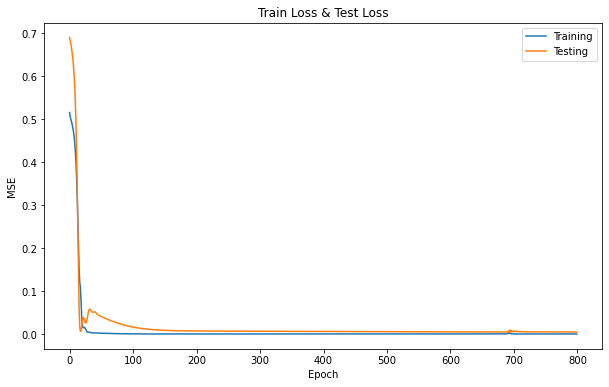

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Train Loss & Test Loss")
plt.show()

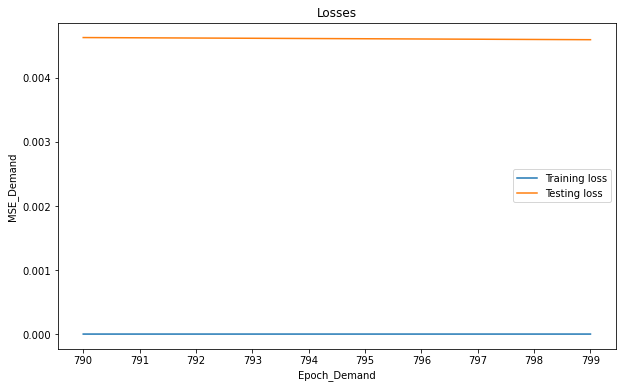

In [19]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 790
end_epoch = 800
plt.figure(figsize=(10,6))
plt.plot(train_loss[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br>
Section 3 : Invert the scaling back to orignal data value <br>
Section 4 : Calculate the RMSE of train and test data 


In [20]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction= torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [21]:
# Section 3 : Invert predictions
y_train_prediction= scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [22]:
print("Test Data\t\t\t\Forecast Data")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data			\Forecast Data
[300.]		[296.58087]
[310.]		[304.95966]
[320.]		[312.9909]
[330.]		[320.66687]
[340.]		[327.98538]
[350.]		[334.94897]
[360.]		[341.5639]
[370.]		[347.83954]
[380.]		[353.78748]
[390.]		[359.42084]


In [23]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

y_test_shape : (10, 1)
y_test_pred_shape : (10, 1)


In [24]:
# Section 4 : Calculate root mean squared error for both train and test data 
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.24 RMSE
Test Score: 17.31 RMSE


# Exercise for Univariate (Solution)

Task : Using LSTM to create a model that can predict lastest sales of shampoo

## Hyperparameter

In [25]:
#Hyperparameter
num_epochs_shampoo = 345
split_ratio = 0.70
batch_size_shampoo = 1
window_size_shampoo = 5

#Hidden Layer for LSTM
hidden_dim = 64

#seed
torch.manual_seed(123)

## Data Preparation

In [26]:
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
shampoo_ts =shampoo['sales']                          

Text(0.5, 1.0, 'Time Series plot ')

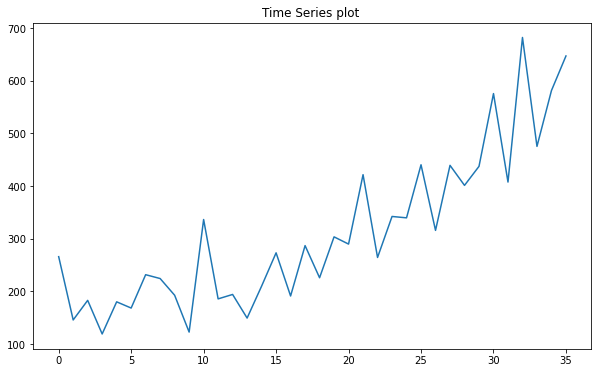

In [27]:
plt.figure(figsize=(10,6))
plt.plot(shampoo_ts ,label = 'Shampoo Sales')
plt.title("Time Series plot ")

### Data Splitting

In [28]:
# Split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

### Data Standardlization 
Standardlize the data into mean = 0 , variance = 1

In [29]:
scaler_shampoo =StandardScaler().fit(shampoo_ts.values.reshape(-1,1))

scaler_shampoo_data = scaler_shampoo.transform(shampoo_ts.values.reshape(-1,1))
scaler_shampoo_data


array([[-0.31732191],
       [-1.13514084],
       [-0.88182806],
       [-1.31627309],
       [-0.90089462],
       [-0.98124652],
       [-0.55020624],
       [-0.59991546],
       [-0.81577608],
       [-1.29175895],
       [ 0.16274665],
       [-0.86276151],
       [-0.80556185],
       [-1.1106267 ],
       [-0.69797202],
       [-0.26761269],
       [-0.82530935],
       [-0.17432277],
       [-0.58970124],
       [-0.06128535],
       [-0.15457527],
       [ 0.74223366],
       [-0.32753614],
       [ 0.20224165],
       [ 0.18453699],
       [ 0.87025194],
       [ 0.02247129],
       [ 0.86276151],
       [ 0.60400115],
       [ 0.84982349],
       [ 1.79021311],
       [ 0.6469009 ],
       [ 2.51542307],
       [ 1.1079029 ],
       [ 1.82970812],
       [ 2.27641021]])

In [30]:
# Visualize data shape after splitting
train_data_shampoo = scaler_shampoo_data[:split_data]
test_data_shampoo = scaler_shampoo_data[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25, 1)
test_data_shampoo_shape
(11, 1)


Text(0.5, 1.0, 'Time Series Graph after split')

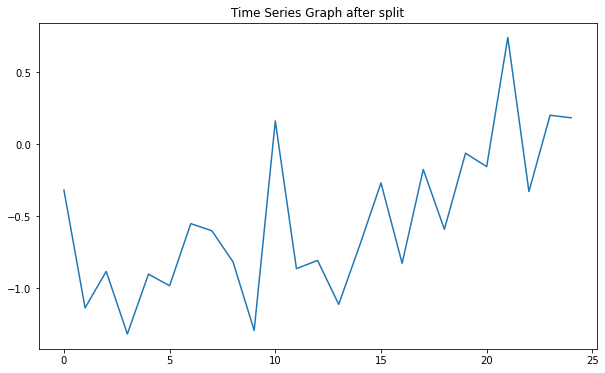

In [31]:
plt.figure(figsize=(10,6))
plt.plot(train_data_shampoo)
plt.title("Time Series Graph after split")

### Data Sequencing 

In [32]:
trainX_shampoo ,trainY_shampoo =  univariate_single_step(train_data_shampoo,window_size_shampoo)
testX_shampoo , testY_shampoo = univariate_single_step(test_data_shampoo,window_size_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:(20, 5, 1) trainY shape:(20, 1)

testX shape:(6, 5, 1) testX shape:(6, 1)


### Data Transform

In [33]:
# Transfrom numpy to Pytorch tensor
# Make training and test sets in torch
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([20, 5, 1]) trainY shape:torch.Size([20, 1])

testX shape:torch.Size([6, 5, 1]) testX shape:torch.Size([6, 1])


### Data Iterator

In [34]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

## Input Model 

The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use :

1. Select one of the model base on the application as below and comment others model
2. IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()
3. IF use stacked LSTM , set num_layer more that 1 and use the model = LSTM()
4. IF use Bidirectional LSTM,use the model = BidirectionalLSTM()

In [35]:
# Arguments for LSTM model
number_of_time_series = 1 
timestep = 1
output_dim =1 

# num_layers : 1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

# Vanila ,Stacked LSTM
model_shampoo = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)

# Bidirectional LSTM
# model_shampoo = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers)



In [36]:
# Define MSE as Loss function 
loss_fn_shampoo = torch.nn.MSELoss()

# Set up optimiser 
optimiser_shampoo = torch.optim.Adam(model_shampoo.parameters(),lr=0.09)

## Training 

In [37]:
# Start Training 
train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

## Evaluate
The first part is plot the Train loss & Test loss as the training goes on 

The second part serve as a function to zoom in certain period on Train loss & Test loss graph to have a clear visualize cause sometime the loss will skew and make us hard to determine the best fit epoch .

For example : The learning curve is skew heavily on the left ,the remaining losses is hard to visualize
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png" width ="500" height=500 >

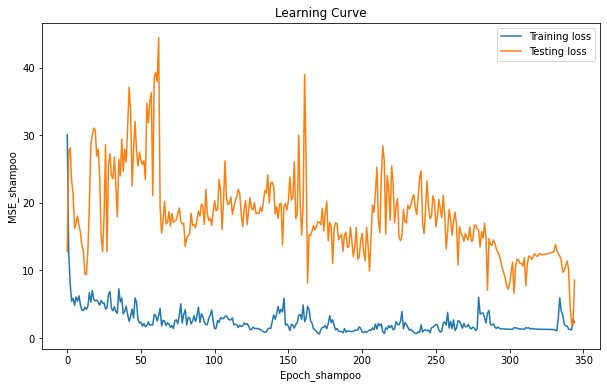

In [38]:
# Plot Learning Curve 
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.title("Learning Curve")
plt.show()

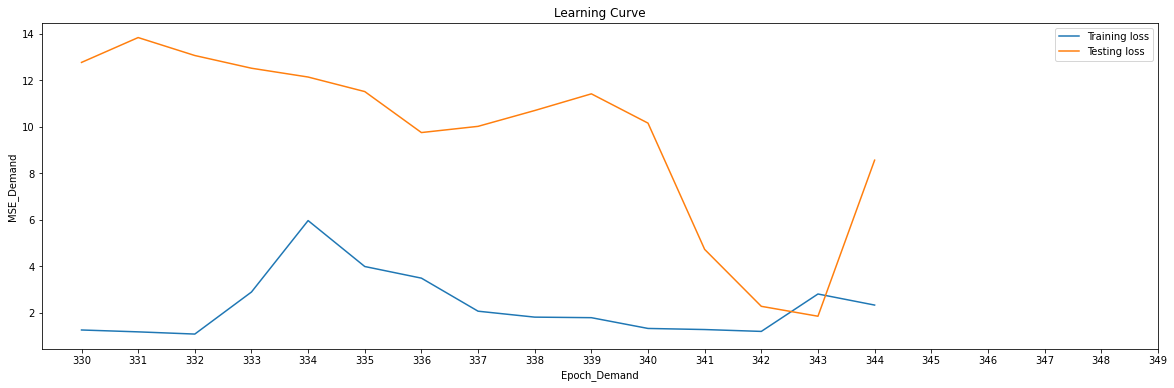

In [39]:
# Zoom in to visualize the graph by fill in start_epoch and end_epoch that want to analyse
start_epoch = 330
end_epoch = 350
plt.figure(figsize=(20,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Learning Curve")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model and plot the forecast result 

In [40]:
# Make predictions
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
    y_test_prediction_shampoo= model_shampoo(testX_shampoo)

# Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [41]:
# Invert predictions
y_train_pred_shampoo = scaler_shampoo.inverse_transform(y_train_prediction_shampoo)
y_train_shampoo = scaler_shampoo.inverse_transform(trainY_shampoo)
y_test_pred_shampoo = scaler_shampoo.inverse_transform(y_test_prediction_shampoo)
y_test_shampoo = scaler_shampoo.inverse_transform(testY_shampoo)

In [42]:
print("y-test\t\ty-predict")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

y-test		y-predict
[575.5]		[367.23096]
[407.6]		[346.09232]
[682.]		[435.73004]
[475.3]		[386.43616]
[581.3]		[434.07306]
[646.89996]		[429.7873]


In [43]:
print(f"y_test_shape : {y_test_shampoo.shape}")   
print(f"y_test_pred_shape : {y_test_pred_shampoo.shape}")

y_test_shape : (6, 1)
y_test_pred_shape : (6, 1)


In [44]:
# Calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 57.49 RMSE
Test Score: 175.37 RMSE


## Result 

In [45]:
test_data_shampoo = scaler_shampoo.inverse_transform(test_data_shampoo)

In [46]:
# Adjustment to make the sequence data plot on original test data 
a=range(split_data+window_size_shampoo,split_data+len(y_test_shampoo)+window_size_shampoo)

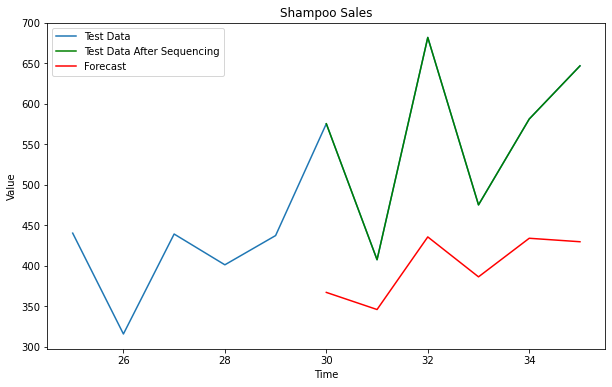

In [47]:
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo, label = 'Test Data')
plt.plot(a,y_test_shampoo, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_pred_shampoo,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Shampoo Sales")
plt.legend()

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)